In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc
import joblib
import shap
import matplotlib.pyplot as plt 
import seaborn as sns

In [27]:
data = pd.read_csv('depression_anxiety_data.csv')

In [28]:
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column].fillna(data[column].mean(), inplace=True)

for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna(data[column].mode()[0], inplace=True)


C:\Users\ry444\AppData\Local\Temp\ipykernel_10032\3614670353.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)
C:\Users\ry444\AppData\Local\Temp\ipykernel_10032\3614670353.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [29]:
data['depression_severity'].unique()

array(['Mild', 'Moderately severe', 'None-minimal', 'Moderate', 'Severe',
       'none'], dtype=object)

In [5]:
data['anxiety_severity'].unique()

array(['Moderate', 'Mild', 'Severe', 'None-minimal', '0'], dtype=object)

In [30]:
scaler = StandardScaler()
numerical_features = ['school_year','age', 'bmi', 'phq_score', 'gad_score','epworth_score']  
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [31]:
label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])


In [32]:
original_labels = label_encoder.classes_  
encoded_labels = range(len(original_labels))

# Print the mapping
for original, encoded in zip(original_labels, encoded_labels):
    print(f"Original: {original} -> Encoded: {encoded}")

Original: female -> Encoded: 0
Original: male -> Encoded: 1


In [33]:

data['anxiety_severity'] = pd.Categorical(data['anxiety_severity'], 
                                           categories=['0','None-minimal', 'Mild', 'Moderate', 'Severe'], 
                                           ordered=True)
data['anxiety_severity'] = data['anxiety_severity'].cat.codes


In [12]:
data['anxiety_severity'].unique()

array([3, 2, 4, 1, 0], dtype=int8)

In [34]:
depression_features = ['age', 'gender', 'bmi', 'phq_score', 'anxiety_severity','epworth_score','gad_score']
X_depression = data[depression_features]
y_depression = data['depression_severity']

In [14]:
X_depression

,age,gender,bmi,phq_score,anxiety_severity,epworth_score,gad_score
0,-0.698559,1,2.173519,0.424101,3,0.156849,0.886690
1,-1.264782,1,-0.784803,0.198049,2,1.918561,-0.383331
2,-0.698559,1,0.368771,0.198049,2,-0.094824,-0.171661
3,-1.264782,0,0.069754,2.684625,4,1.163542,1.733370
4,-1.264782,1,0.481668,-0.254056,3,-0.849843,1.521700
...,...,...,...,...,...,...,...
778,2.132557,0,-0.509644,-0.254056,1,-0.849843,-1.230012
779,1.000111,1,0.413994,-0.706161,2,-0.849843,-0.171661
780,1.000111,1,-0.153505,-1.158266,2,-0.598170,-0.383331
781,1.000111,0,-0.084935,2.232521,4,2.170234,2.580051


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_depression, y_depression, test_size=0.2, random_state=42)


In [36]:
depression_model = RandomForestClassifier(random_state=42)
depression_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
y_pred = depression_model.predict(X_test)
print("Depression Severity Detection:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy_score(y_test,y_pred)

Depression Severity Detection:
[[66  0  0  0  0  0]
 [ 0 24  0  0  0  0]
 [ 0  1 12  0  0  0]
 [ 0  0  0 50  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  1  0  2]]
                   precision    recall  f1-score   support

             Mild       1.00      1.00      1.00        66
         Moderate       0.96      1.00      0.98        24
Moderately severe       1.00      0.92      0.96        13
     None-minimal       0.98      1.00      0.99        50
           Severe       1.00      1.00      1.00         1
             none       1.00      0.67      0.80         3

         accuracy                           0.99       157
        macro avg       0.99      0.93      0.95       157
     weighted avg       0.99      0.99      0.99       157



0.9872611464968153

In [65]:
y_pred_proba = depression_model.predict_proba(X_test)[:, 1]  
pos_label = ['Severe'][0]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=pos_label)  #
roc_auc = auc(fpr, tpr)

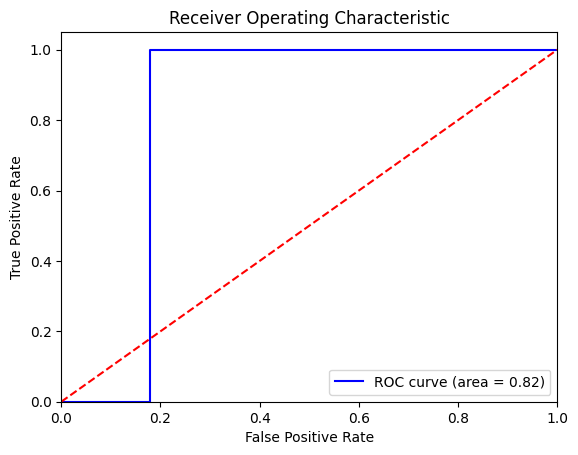

In [66]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [38]:
importances = depression_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': depression_features,
    'Importance': importances
})

In [39]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
3,phq_score,0.688664
6,gad_score,0.103693
2,bmi,0.068966
5,epworth_score,0.054448
4,anxiety_severity,0.040711
0,age,0.032137
1,gender,0.011380


In [40]:
import joblib

# Save the anxiety model
joblib.dump(depression_model, 'depression_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [23]:
def shap_analysis(model, input_data):

    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(input_data)

    if isinstance(shap_values, list):
        shap_values = shap_values[0] 

    # Convert input_data to DataFrame
    input_df = pd.DataFrame(input_data, columns=[
        'Age', 'Gender', 'BMI', 'PHQ Score', 'Anxiety Severity', 'Epworth Score', 'GAD Score'
    ])

    # Create simple summary plot
    shap.summary_plot(shap_values, input_df)

In [68]:
def predict_anxiety_severity():
    # Load the saved model and label encoder
    depression_model = joblib.load('depression_model.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    
    try:
        age = float(input("Enter age: "))
        gender = input("Enter gender (male/female): ")
        bmi = float(input("Enter BMI: "))
        phq_score = float(input("Enter PHQ Score: "))
        anxiety_severity = input("Enter Anxiety Severity: ")
        epworth_score = float(input("Enter epworth Score: "))
        gad_score = float(input("Enter gad Score: "))
    except ValueError:
        print("Error: Please enter valid numerical values for age, BMI, and PHQ Score.")
        return
    
    input_data = np.array([[age, gender, bmi, phq_score, anxiety_severity,epworth_score,gad_score]], dtype=float)
    
    # Make prediction
    prediction = depression_model.predict(input_data)

    
    print(f"Predicted Anxiety Severity: {prediction[0]}")

    input_data = input_data.reshape(1, -1)
    shap_analysis(depression_model, input_data)


g:\AnacondaIDE\envs\sign\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predicted Anxiety Severity: Moderate


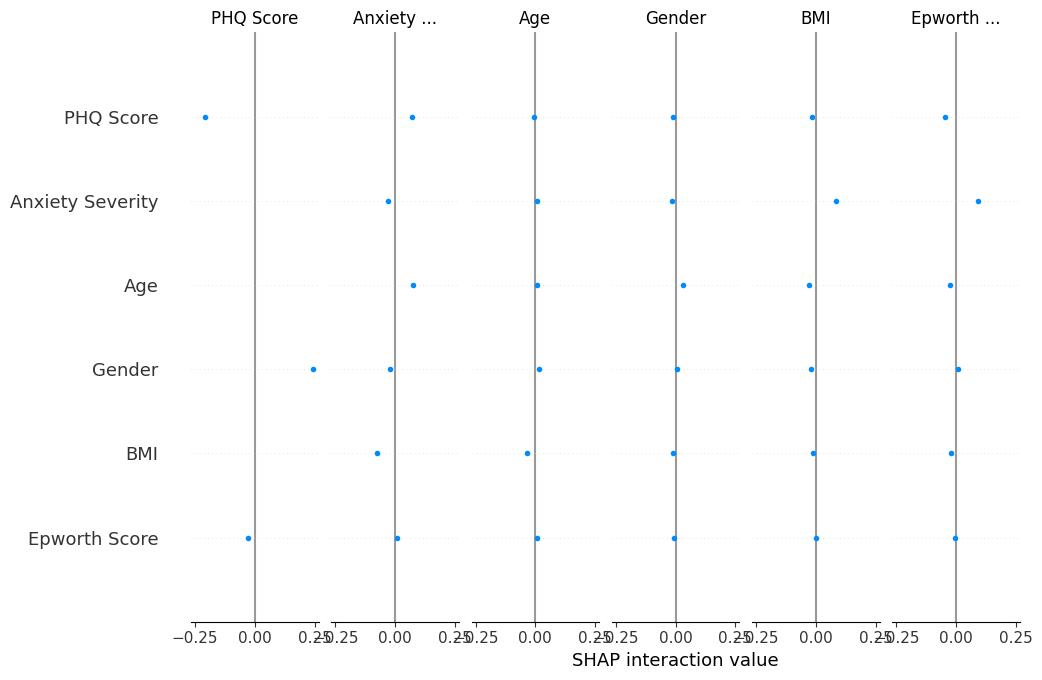

In [70]:
predict_anxiety_severity()

#Other Models


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X_depression, y_depression, test_size=0.2, random_state=42)

# List of models 
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

Model: Random Forest
[[66  0  0  0  0  0]
 [ 0 24  0  0  0  0]
 [ 0  1 12  0  0  0]
 [ 0  0  0 50  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  1  0  2]]
                   precision    recall  f1-score   support

             Mild       1.00      1.00      1.00        66
         Moderate       0.96      1.00      0.98        24
Moderately severe       1.00      0.92      0.96        13
     None-minimal       0.98      1.00      0.99        50
           Severe       1.00      1.00      1.00         1
             none       1.00      0.67      0.80         3

         accuracy                           0.99       157
        macro avg       0.99      0.93      0.95       157
     weighted avg       0.99      0.99      0.99       157

Accuracy: 0.9872611464968153

Model: Logistic Regression
[[64  0  0  2  0  0]
 [ 6 18  0  0  0  0]
 [ 0  5  8  0  0  0]
 [ 6  0  0 44  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  3  0  0]]
                   precision    recall  f1-score   support

             Mi

g:\AnacondaIDE\envs\sign\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
g:\AnacondaIDE\envs\sign\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\AnacondaIDE\envs\sign\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

Model: Gradient Boosting
[[66  0  0  0  0  0]
 [ 0 24  0  0  0  0]
 [ 0  0 13  0  0  0]
 [ 0  0  0 50  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  3]]
                   precision    recall  f1-score   support

             Mild       1.00      1.00      1.00        66
         Moderate       1.00      1.00      1.00        24
Moderately severe       1.00      1.00      1.00        13
     None-minimal       1.00      1.00      1.00        50
           Severe       1.00      1.00      1.00         1
             none       1.00      1.00      1.00         3

         accuracy                           1.00       157
        macro avg       1.00      1.00      1.00       157
     weighted avg       1.00      1.00      1.00       157

Accuracy: 1.0

Model: K-Nearest Neighbors
[[60  1  0  5  0  0]
 [ 9 15  0  0  0  0]
 [ 0  6  7  0  0  0]
 [13  0  0 37  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0  3  0  0]]
                   precision    recall  f1-score   support

             Mild       0.

g:\AnacondaIDE\envs\sign\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\AnacondaIDE\envs\sign\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\AnacondaIDE\envs\sign\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Neural Network
[[65  0  0  1  0  0]
 [ 0 24  0  0  0  0]
 [ 0  2 10  0  1  0]
 [ 0  0  0 50  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  1  0  2]]
                   precision    recall  f1-score   support

             Mild       1.00      0.98      0.99        66
         Moderate       0.92      1.00      0.96        24
Moderately severe       1.00      0.77      0.87        13
     None-minimal       0.96      1.00      0.98        50
           Severe       0.50      1.00      0.67         1
             none       1.00      0.67      0.80         3

         accuracy                           0.97       157
        macro avg       0.90      0.90      0.88       157
     weighted avg       0.97      0.97      0.97       157

Accuracy: 0.9681528662420382



g:\AnacondaIDE\envs\sign\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
